In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as g
from tqdm import tqdm
import gc

In [2]:
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

trans_cat_cols = ["ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2",
                   "M1","M2","M3","M4","M5","M6","M7","M8","M9"]

iden_cat_cols = ["DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32","id_33","id_34","id_35","id_36",
                   "id_37","id_38"]

categorical_cols = trans_cat_cols + iden_cat_cols

def transform_catcols(df1, df2, cols):
    for cat_col in tqdm(cols): 
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cols].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cols].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cols].dropna() ), set(df2[cols].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cols].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cols].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] = np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] = np.NaN
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect()
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

### - 데이터로드 (저장용 작업)

In [18]:
train_t = pd.read_csv('./data/train_transaction.csv')
train_i = pd.read_csv('./data/train_identity.csv')
test_t = pd.read_csv('./data/test_transaction.csv')
test_i = pd.read_csv('./data/test_identity.csv')

In [31]:
train_t = reduce_mem_usage(train_t)
train_i = reduce_mem_usage(train_v)
test_t = reduce_mem_usage(test_t)
test_i = reduce_mem_usage(test_v)

Mem. usage decreased to 542.35 Mb (0.0% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [ ]:
train = pd.merge(train_t, train_i, on='TransactionID', how='left')
test = pd.merge(test_t, test_i, on='TransactionID', how='left')

In [36]:
gc.collect()

1094

In [54]:
test.columns = [c.replace('-', '_') if '-' in c else c for c in test.columns]

In [56]:
test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa

In [58]:
train = train[train_cols]
test = test[test_cols]

In [60]:
train.shape, test.shape

((590540, 223), (506691, 222))

In [62]:
train.to_csv('train3.csv')
test.to_csv('test3.csv')

### - 데이터로드

In [7]:
train = pd.read_csv('train3.csv').drop(columns='Unnamed: 0')
test = pd.read_csv('test3.csv').drop(columns='Unnamed: 0')

In [8]:
train.shape, test.shape

((590540, 223), (506691, 222))

In [42]:
# train_cols = ['isFraud',
              'TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 'V310',
 'V320',
 'V281',
 'V283',
 'V289',
 'V296',
 'V301',
 'V314',
 'V332',
 'V325',
 'V335',
 'V338']

In [44]:
# test_cols = ['TransactionID',
             'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V162',
 'V165',
 'V160',
 'V166',
 'V178',
 'V176',
 'V173',
 'V182',
 'V187',
 'V203',
 'V205',
 'V207',
 'V215',
 'V169',
 'V171',
 'V175',
 'V180',
 'V185',
 'V188',
 'V198',
 'V210',
 'V209',
 'V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277',
 'V220',
 'V221',
 'V234',
 'V238',
 'V250',
 'V271',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 'V310',
 'V320',
 'V281',
 'V283',
 'V289',
 'V296',
 'V301',
 'V314',
 'V332',
 'V325',
 'V335',
 'V338']

In [9]:
selectd_cols = ['TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V96',
 'V98',
 'V99',
 'V104',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V294',
 'V284',
 'V285',
 'V286',
 'V291',
 'V297',
 'V303',
 'V305',
 'V307',
 'V309',
 'V310',
 'V320',
 'V281',
 'V283',
 'V289',
 'V296',
 'V301',
 'V314',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain']

In [10]:
y = train['isFraud']
train = train[selectd_cols]
test = test[selectd_cols]

In [11]:
y.shape, train.shape, test.shape

((590540,), (590540, 102), (506691, 102))

In [ ]:
train['TransactionDay'] = np.floor(train['TransactionDT'] / (24*60*60))

# 거래 금액 범주화
train['TransactionAmtRange'] = pd.qcut(train['TransactionAmt'], 10, labels=False)

# uid 생성
train['uid'] = train['card1'].astype(str) + '_' + \
               train['card2'].astype(str) + '_' + \
               train['addr1'].astype(str) + '_' + \
               train['addr2'].astype(str) + '_' + \
               train['TransactionDay'].astype(str) + '_' + \
               train['ProductCD'].astype(str)

# 그룹별 통계 계산
uid_stats = train.groupby('uid').agg({
    'TransactionAmt': ['mean', 'sum', 'count'],
    'TransactionDT': ['min', 'max'],
    'TransactionDay': 'count'
}).reset_index()

# 멀티인덱스 컬럼을 단일 레벨로 변환
uid_stats.columns = ['_'.join(col).strip() for col in uid_stats.columns.values]

In [120]:
test['TransactionDay'] = np.floor(test['TransactionDT'] / (24*60*60))

# 거래 금액 범주화
test['TransactionAmtRange'] = pd.qcut(test['TransactionAmt'], 10, labels=False)

# uid 생성
test['uid'] = test['card1'].astype(str) + '_' + \
               test['card2'].astype(str) + '_' + \
               test['addr1'].astype(str) + '_' + \
               test['addr2'].astype(str) + '_' + \
               test['TransactionDay'].astype(str) + '_' + \
               test['ProductCD'].astype(str)

# 그룹별 통계 계산
uid_stats = test.groupby('uid').agg({
    'TransactionAmt': ['mean', 'sum', 'count'],
    'TransactionDT': ['min', 'max'],
    'TransactionDay': 'count'
}).reset_index()

# 멀티인덱스 컬럼을 단일 레벨로 변환
uid_stats.columns = ['_'.join(col).strip() for col in uid_stats.columns.values]

In [121]:
uid_stats['TransactionDT_min'] = (uid_stats['TransactionDT_min'] - uid_stats['TransactionDT_min'].mean()) / uid_stats['TransactionDT_min'].std()
uid_stats['TransactionDT_max'] = (uid_stats['TransactionDT_max'] - uid_stats['TransactionDT_max'].mean()) / uid_stats['TransactionDT_max'].std()

In [124]:
uid_stats = uid_stats.rename(columns={'uid_': 'uid'})

In [39]:
train['uid2'] = train['card1'].astype(str) + '_' + \
               train['card2'].astype(str) + '_' + \
               train['addr1'].astype(str) + '_' + \
               train['addr2'].astype(str) + '_' + \
               train['D1'].astype(str)

uid_stats2 = train.groupby('uid2').agg({
    'TransactionAmt': ['mean', 'sum', 'count'],
    'TransactionDT': ['min', 'max'],
    'C1': ['mean'],
    'C2': ['mean'], 
}).reset_index()

uid_stats2.columns = ['_'.join(col).strip() for col in uid_stats2.columns.values]

In [126]:
test['uid2'] = test['card1'].astype(str) + '_' + \
               test['card2'].astype(str) + '_' + \
               test['addr1'].astype(str) + '_' + \
               test['addr2'].astype(str) + '_' + \
               test['D1'].astype(str)

uid_stats2 = test.groupby('uid2').agg({
    'TransactionAmt': ['mean', 'sum', 'count'],
    'TransactionDT': ['min', 'max'],
    'C1': ['mean'],
    'C2': ['mean'], 
}).reset_index()

uid_stats2.columns = ['_'.join(col).strip() for col in uid_stats2.columns.values]

In [127]:
uid_stats2['TransactionDT_min'] = (uid_stats2['TransactionDT_min'] - uid_stats2['TransactionDT_min'].mean()) / uid_stats2['TransactionDT_min'].std()
uid_stats2['TransactionDT_max'] = (uid_stats2['TransactionDT_max'] - uid_stats2['TransactionDT_max'].mean()) / uid_stats2['TransactionDT_max'].std()

In [130]:
uid_stats2 = uid_stats2.rename(columns={'uid2_': 'uid2'})

In [144]:
test = test.merge(uid_stats, on='uid', how='left')
test = test.merge(uid_stats2, on='uid2', how='left')

In [79]:
train.dtypes

TransactionDT             float64
TransactionAmt            float64
card1                       int64
card2                     float64
card3                     float64
                           ...   
TransactionAmt_count_y      int64
TransactionDT_min_y       float64
TransactionDT_max_y       float64
C1_mean                   float64
C2_mean                   float64
Length: 119, dtype: object

In [81]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# scaler = StandardScaler()
# for col in ['TransactionDT','TransactionAmt']:
#     test[col] = scaler.fit_transform(test[[col]])

In [83]:
from sklearn.preprocessing import LabelEncoder

def label_encod(train, test):
    for col in tqdm(train.columns):
        if train[col].dtype == 'object':
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))  

    return train, test

def preprocessing(train, test, categorical_cols=categorical_cols):
    for col in tqdm(train.columns):
        if train[col].dtype == 'O':
            train[col] = train[col].fillna('unseen_before_label')
            test[col]  = test[col].fillna('unseen_before_label')
            
            train[col] = train[col].astype(str)
            test[col] = test[col].astype(str)
            
        if train[col].dtype == 'object':
            train[col] = train[col].astype(float).fillna(-999)
            test[col]  = test[col].astype(float).fillna(-999)
            
            le = LabelEncoder()
            le.fit(list(train[col])+list(test[col]))
            train[col] = le.transform(train[col])
            test[col]  = le.transform(test[col])

In [87]:
def label_encod(train):
    for col in tqdm(train.columns):
        if train[col].dtype == 'object':
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
    return train

train_encode = label_encod(train)

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.26it/s]


In [146]:
test_encode = label_encod(test)

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.80it/s]


In [152]:
train_encode.shape, test_encode.shape

((590540, 110), (506691, 110))

In [107]:
train_encode = train_encode.drop(columns=['TransactionDT',
                                          'card1',
                                         'card2',
                                         'card3',
                                         'card5',
                                         'addr1',
                                         'addr2',
                                         'card4',
                                         'card6'],axis=0)

In [150]:
test_encode = test_encode.drop(columns=['TransactionDT',
                                          'card1',
                                         'card2',
                                         'card3',
                                         'card5',
                                         'addr1',
                                         'addr2',
                                         'card4',
                                         'card6'],axis=0)

In [166]:
test_encode = test_encode.drop(columns=['uid','uid2'],axis=0)
train_encode = train_encode.drop(columns=['uid','uid2'],axis=0)

In [168]:
train_encode.shape, test_encode.shape

((590540, 108), (506691, 108))

In [170]:
from sklearn.model_selection import train_test_split

X_tr, X_v, y_tr, y_v = train_test_split(train_encode, y, test_size=0.25,
                                       random_state=2024,
                                       stratify=y)

In [172]:
X_tr.shape, X_v.shape, y_tr.shape, y_v.shape

((442905, 108), (147635, 108), (442905,), (147635,))

In [174]:
import lightgbm as lgb

train_data = lgb.Dataset(X_tr, label=y_tr)
valid_data = lgb.Dataset(X_v, label=y_v)

In [176]:
params = {
    'objective': 'binary',
    'metric': 'auc'
}

In [178]:
callbacks = [lgb.early_stopping(stopping_rounds=100), 
             lgb.log_evaluation(period=100)]
clf = lgb.train(params, train_data, 
                num_boost_round = 10000, 
                valid_sets = [train_data, valid_data],
                callbacks=callbacks)

[LightGBM] [Info] Number of positive: 15497, number of negative: 427408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14142
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317093
[LightGBM] [Info] Start training from score -3.317093
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.931511	valid_1's auc: 0.914079
[200]	training's auc: 0.953237	valid_1's auc: 0.926011
[300]	training's auc: 0.965382	valid_1's auc: 0.932072
[400]	training's auc: 0.972746	valid_1's auc: 0.935081
[500]	training's auc: 0.979101	valid_1's auc: 0.938757
[600]	training's auc: 0.983268	valid_1's auc: 0.939962
[700]	training's auc: 0.986857	valid_1's auc: 

In [180]:
preds = clf.predict(test_encode)

In [181]:
sub1 = pd.read_csv("./data/sample_submission.csv")
sub1['isFraud'] = preds
sub1.to_csv('result_04.csv', index=False)

In [63]:
train.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'C1',
       ...
       'V283', 'V289', 'V296', 'V301', 'V314', 'ProductCD', 'card4', 'card6',
       'P_emaildomain', 'R_emaildomain'],
      dtype='object', length=102)

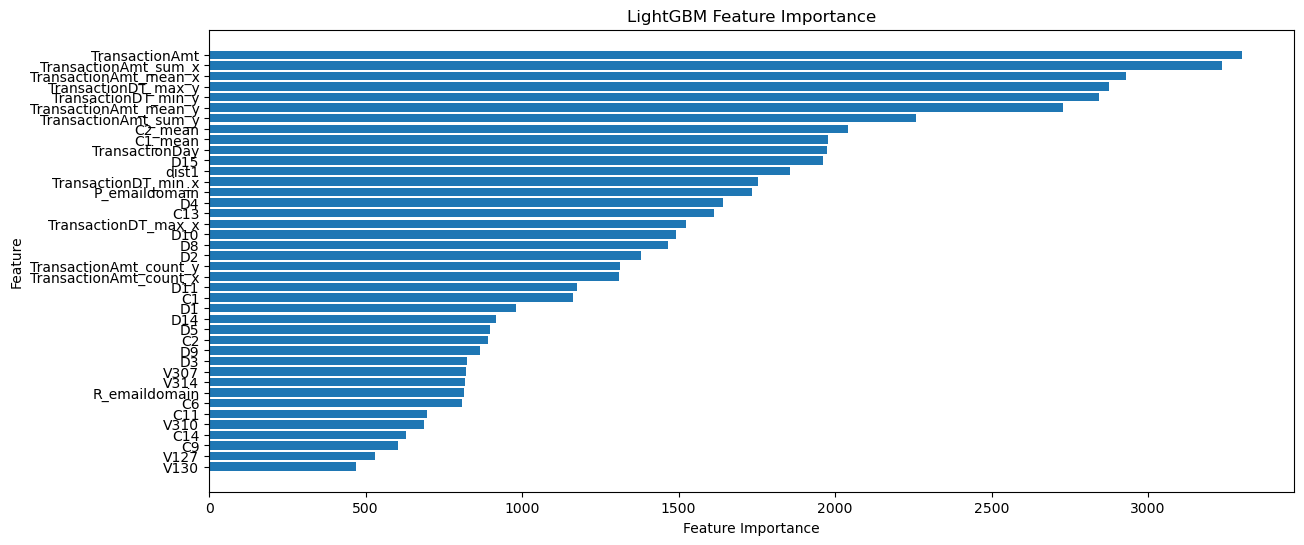

In [184]:
importance = clf.feature_importance()
feature_names = train_encode.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(40)

# print(feature_importance_df)

# 피처 임포턴스 시각화
plt.figure(figsize=(14, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [63]:
print(feature_importance_df[:20]) # 1번째

           feature  importance
3            card1        4738
0    TransactionDT        4525
1   TransactionAmt        4232
4            card2        4062
9            addr1        3699
38             D10        1790
32              D4        1790
11           dist1        1658
13   P_emaildomain        1612
7            card5        1507
27             C13        1434
39             D11        1321
30              D2        1166
15              C1         955
36              D8         946
33              D5         941
29              D1         892
31              D3         858
16              C2         784
12           dist2         745


In [124]:
print(feature_importance_df[:20]) # 0번쨰

           feature  importance
4            card1        5376
0    TransactionID        5159
2   TransactionAmt        4877
5            card2        4705
10           addr1        4299
44             D15        2674
33              D4        2062
39             D10        1931
12           dist1        1930
8            card5        1849
14   P_emaildomain        1793
28             C13        1790
40             D11        1583
31              D2        1354
16              C1        1158
37              D8        1077
34              D5        1021
32              D3         972
30              D1         969
17              C2         871


#### preprocessing(X,test)

In [104]:
X.isnull().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
V314                1269
V332              508189
V325              508189
V335              508189
V338              508189
Length: 222, dtype: int64